Data taken from: https://github.com/teddykoker/quant/tree/master/survivorship-free under data.zip

Momentum copied from: https://github.com/teddykoker/blog/blob/master/_notebooks/2019-05-19-momentum-strategy-from-stocks-on-the-move-in-python.ipynb

In [22]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


plt.rcParams["figure.figsize"] = (10, 6)  # (w, h)
# plt.ioff()


In [23]:
tickers = pd.read_csv('data/tickers.csv')["<TICKER>"].tolist()

# create a list of series with name as ticker
allTickersData = [
    pd.read_csv(f"data/wse stocks/{ticker}.txt",
                index_col='<DATE>',
                parse_dates=True)['<CLOSE>'].rename(ticker) for ticker in tickers]

stocks = pd.concat(allTickersData, axis=1, sort=True)

stocks = stocks.loc[:, ~stocks.columns.duplicated()]
# todo how to rename index


In [24]:
from scipy.stats import linregress


def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    # annualize slope and multiply by R^2
    return ((1 + slope) ** 252) * (rvalue ** 2)


In [25]:
momentums = stocks.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)


In [26]:
print(momentums)


                 06n  08n       11b       1at  3rg       4fm  aat       abe  \
<DATE>                                                                        
1987-01-02       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1987-01-05       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1987-01-07       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1987-01-08       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1987-01-09       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
...              ...  ...       ...       ...  ...       ...  ...       ...   
2022-02-14  0.205704  NaN  2.551795  0.162095  NaN  1.208144  NaN  0.277125   
2022-02-15  0.215077  NaN  2.448712  0.162345  NaN  1.249493  NaN  0.279642   
2022-02-16  0.230885  NaN  2.343078  0.168387  NaN  1.302438  NaN  0.282820   
2022-02-17  0.244294  NaN  2.187248  0.165202  NaN  1.344426  NaN  0.282737   
2022-02-18  0.256143  NaN  2.065882  0.154031  NaN  

ValueError: x and y must have same first dimension, but have shapes (180,) and (150,)

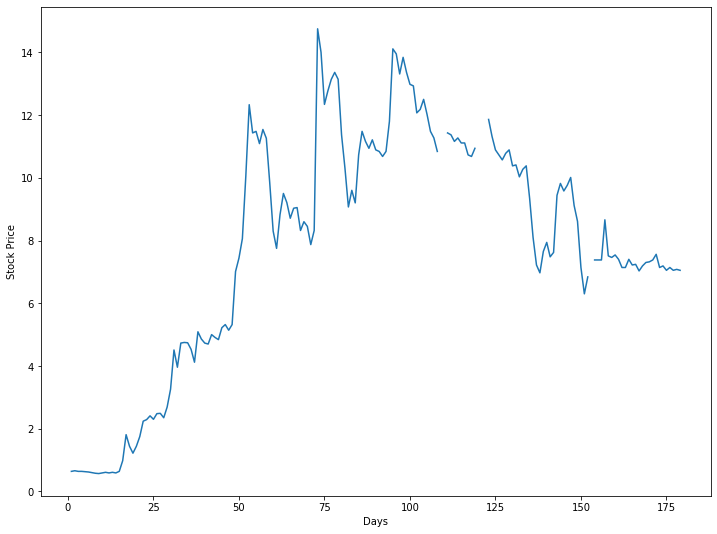

In [27]:
plt.figure(figsize=(12, 9))
plt.xlabel('Days')
plt.ylabel('Stock Price')

bests = momentums.max().sort_values(ascending=False).index[:5]
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(stocks[best].iloc[end - 90: end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), stocks[best][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))


In [ ]:
print(momentums)


                 06n  08n       11b       1at  3rg       4fm  aat       abe  \
<DATE>                                                                        
1997-06-12       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1997-06-13       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1997-06-16       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1997-06-17       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
1997-06-18       NaN  NaN       NaN       NaN  NaN       NaN  NaN       NaN   
...              ...  ...       ...       ...  ...       ...  ...       ...   
2022-02-14  0.205704  NaN  2.551795  0.162095  NaN  1.208144  NaN  0.277125   
2022-02-15  0.215077  NaN  2.448712  0.162345  NaN  1.249493  NaN  0.279642   
2022-02-16  0.230885  NaN  2.343078  0.168387  NaN  1.302438  NaN  0.282820   
2022-02-17  0.244294  NaN  2.187248  0.165202  NaN  1.344426  NaN  0.282737   
2022-02-18  0.256143  NaN  2.065882  0.154031  NaN  

Below is a implementation of strategy using backtrader framework, for reference check:
https://www.backtrader.com/docu/quickstart/quickstart/

In [28]:
import backtrader as bt


class Momentum(bt.Indicator):
    lines = ('trend',)
    params = (('period', 90),)

    def __init__(self):
        self.addminperiod(self.params.period)

    def next(self):
        returns = np.log(self.data.get(size=self.p.period))
        x = np.arange(len(returns))
        slope, _, rvalue, _, _ = linregress(x, returns)
        annualized = (1 + slope) ** 252
        self.lines.trend[0] = annualized * (rvalue ** 2)


class Strategy(bt.Strategy):
    def __init__(self):
        self.i = 0
        self.inds = {}
        self.spy = self.datas[0]
        self.stocks = self.datas[1:]

        self.spy_sma200 = bt.indicators.SimpleMovingAverage(self.spy.close,
                                                            period=200)
        for d in self.stocks:
            self.inds[d] = {}
            self.inds[d]["momentum"] = Momentum(d.close,
                                                period=90)
            self.inds[d]["sma100"] = bt.indicators.SimpleMovingAverage(d.close,
                                                                       period=100)
            self.inds[d]["atr20"] = bt.indicators.ATR(d,
                                                      period=20)

    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()

    def next(self):
        if self.i % 5 == 0:
            self.rebalance_portfolio()
        if self.i % 10 == 0:
            self.rebalance_positions()
        self.i += 1

    def rebalance_portfolio(self):
        # only look at data that we can have indicators for
        self.rankings = list(filter(lambda d: len(d) > 100, self.stocks))
        self.rankings.sort(key=lambda d: self.inds[d]["momentum"][0])
        num_stocks = len(self.rankings)

        # sell stocks based on criteria
        for i, d in enumerate(self.rankings):
            if self.getposition(self.data).size:
                if i > num_stocks * 0.2 or d < self.inds[d]["sma100"]:
                    self.close(d)

        if self.spy < self.spy_sma200:
            return

        # buy stocks with remaining cash
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(self.data).size:
                size = value * 0.001 / self.inds[d]["atr20"]
                self.buy(d, size=size)

    def rebalance_positions(self):
        num_stocks = len(self.rankings)

        if self.spy < self.spy_sma200:
            return

        # rebalance all stocks
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            size = value * 0.001 / self.inds[d]["atr20"]
            self.order_target_size(d, size)


In [29]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

spy = pd.read_csv(f"data/wse indices/wig.txt",
                  parse_dates=True,
                  index_col='<DATE>')

spy = spy.rename(columns={
    "<DATE>": "date",
    "<TICKER>": "ticker",
    "<PER>": "per",
    "<TIME>": "time",
    "<OPEN>": "open",
    "<HIGH>": "high",
    "<LOW>": "low",
    "<CLOSE>": "close",
    "<VOL>": "volume",
    "<OPENINT>": "openint"
})

cerebro.adddata(bt.feeds.PandasData(dataname=spy, plot=False))  # add WIG Index

for ticker in tickers:
    df = pd.read_csv(f"data/wse stocks/{ticker}.txt",
                     parse_dates=True,
                     index_col='<DATE>')
    if len(df) > 100:  # data must be long enough to compute 100 day SMA
        df = df.rename(columns={
            "<DATE>": "date",
            "<TICKER>": "ticker",
            "<PER>": "per",
            "<TIME>": "time",
            "<OPEN>": "open",
            "<HIGH>": "high",
            "<LOW>": "low",
            "<CLOSE>": "close",
            "<VOL>": "volume",
            "<OPENINT>": "openint"
        })
        cerebro.adddata(bt.feeds.PandasData(dataname=df, plot=False))

cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(Strategy)
results = cerebro.run()


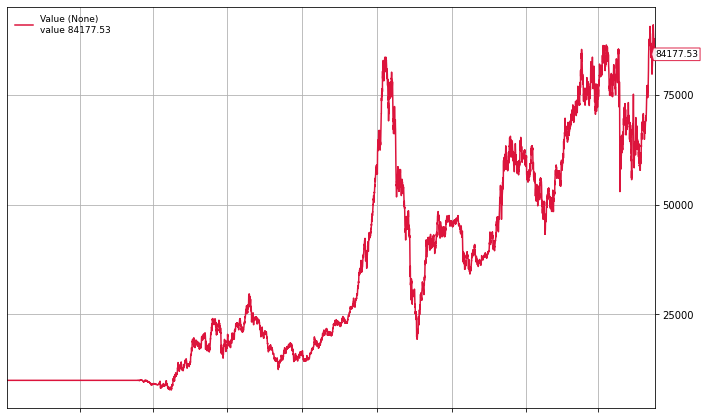

Sharpe: 0.348
Norm. Annual Return: 6.18%
Max Drawdown: 76.83%


In [30]:
cerebro.plot(iplot=False)[0][0]
print(
    f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(
    f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(
    f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")


In [31]:
print(results)
